In [1]:
import numpy as np
import os
import json
import collections as col
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
TRAINING_PATH = 'D:/software/Python/snli_1.0/snli_1.0_train.jsonl'
DEV_PATH = 'D:/software/Python/snli_1.0/snli_1.0_dev.jsonl'
TEST_PATH = 'D:/software/Python/snli_1.0/snli_1.0_test.jsonl'

TRAINING_VECTORS_PATH = 'D:/software/Python/NLP/nostoplist_csr.npz'
DEV_VECTORS_PATH = 'D:/software/Python/NLP/nostoplist_dev_csr.npz'
TEST_VECTORS_PATH = ''

SAVE_TO_FILE = False
LOAD_FROM_FILE = False

STOP = stopwords.words('english')

In [3]:
def save_sparse_vectors(file_name, array, labels):
    np.savez(file_name, data = array.data, indices = array.indices, indptr = array.indptr, shape = array.shape, label_data = labels)

def load_sparse_vectors(file_name):
    loader = np.load(file_name)
    return (csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape = loader['shape']), loader['label_data'])

In [4]:
def pos_stoplist(pos):
    return pos == 'NN' or pos == 'JJ' or 'VB' in pos

def pos_strip(sentence_parse, stoplist_function):
    m = re.finditer('\((\w+) (\w+)\)', sentence_parse)
    tags = [(match.group(2), match.group(1)) for match in m]
    return tags

def word_strip(sentence):
    return [i for i in re.findall("\w+", sentence.lower())]

def extract_pair(line):
    json_pair = json.loads(line)
    pair = {'sentence1': word_strip(json_pair['sentence1']),
            'sentence1_pos': pos_strip(json_pair['sentence1_parse'], pos_stoplist),
            'sentence2': word_strip(json_pair['sentence2']),
            'sentence2_pos': pos_strip(json_pair['sentence2_parse'], pos_stoplist),
            'label': json_pair['gold_label']}
    return pair

In [81]:
def cross_unigram_counter(pair):
    cross_unigrams = []
    for word1 in pair['sentence1']:
        for word2 in pair['sentence2']:
            cross_unigrams.append(word1 + '-' + word2)

    return col.Counter(cross_unigrams)

def cross_unigram_stoplist_counter(pair):
    sentence1 = (word for word in pair['sentence1'] if word not in STOP)
    sentence2 = (word for word in pair['sentence2'] if word not in STOP)
    
    cross_unigrams = []
    for word1 in sentence1:
        for word2 in sentence2:
            cross_unigrams.append((word1, word2))

    return col.Counter(cross_unigrams)

def cross_unigram_pos_stoplist_counter(pair):
    sentence1 = (match for match in pair['sentence1_pos'] if pos_stoplist(match[1]))
    sentence2 = (match for match in pair['sentence2_pos'] if pos_stoplist(match[1]))
    
    cross_unigrams = []
    for match1 in sentence1:
        for match2 in sentence2:
            cross_unigrams.append((match1, match2))

    return col.Counter(cross_unigrams)

def cross_unigram_pos_counter(pair):
    cross_unigrams = []
    for word1 in pair['sentence1_pos']:
        for word2 in pair['sentence2_pos']:
            cross_unigrams.append(word1[0] + '_' + word1[1] + '-' + word2[0] + '_' + word2[1])

    return col.Counter(cross_unigrams)

def cross_unigram_pos_justwords_counter(pair):
    cross_unigrams = []
    for word1 in pair['sentence1_pos']:
        for word2 in pair['sentence2_pos']:
            cross_unigrams.append((word1[0], word2[0]))

    return col.Counter(cross_unigrams)

def extract_pairs(file_path):
    with open(file_path, 'rb') as f:
        for line in f:
            yield extract_pair(line)

def extract_counters(pairs, feature_extractor):
    for pair in pairs:
        yield feature_extractor(pair)

def calculate_vectors(training_path, testing_path, feature_extractor):
    print 'Calculating Labels'
    labels = [pair['label'] for pair in extract_pairs(training_path)]
    dev_labels = [pair['label'] for pair in extract_pairs(testing_path)]
 
    print 'Training Vectorizer'
    vectorizer = DictVectorizer()

    print 'Training Vectorizer'
    vectors = vectorizer.fit_transform(extract_counters(extract_pairs(training_path), feature_extractor))
    print 'Vectorizing unigrams'
    dev_vectors = vectorizer.transform(extract_counters(extract_pairs(testing_path), feature_extractor))

    feature_names = vectorizer.get_feature_names()
    
    if SAVE_TO_FILE:
        print 'Saving to File'
        save_sparse_vectors(TRAINING_VECTORS_PATH, vectors, labels)
        save_sparse_vectors(DEV_VECTORS_PATH, dev_vectors, dev_labels)

    return (vectors, labels, dev_vectors, dev_labels, feature_names)

In [89]:
%time vectors, labels, dev_vectors, dev_labels, feature_names = calculate_vectors(TRAINING_PATH, DEV_PATH, cross_unigram_pos_counter)
print vectors.shape

Calculating Labels
Training Vectorizer
Training Vectorizer
Vectorizing unigrams
Wall time: 4min 33s
(550152, 4887280)


In [32]:
save_sparse_vectors(TRAINING_VECTORS_PATH, vectors, labels)
save_sparse_vectors(DEV_VECTORS_PATH, dev_vectors, dev_labels)

In [7]:
vectors, labels = load_sparse_vectors(TRAINING_VECTORS_PATH)
dev_vectors, dev_labels = load_sparse_vectors(DEV_VECTORS_PATH)

In [83]:
print '-' * 10
print 'neutral'
print '-' * 10
ordered = np.argsort(perceptron.coef_[0])
for i in range(0,10):
    print feature_names[ordered[i]]

print '-' * 10
print 'entailment'
print '-' * 10
ordered = np.argsort(perceptron.coef_[1])
for i in range(0,10):
    print feature_names[ordered[i]]
    
print '-' * 10
print 'contradiction'
print '-' * 10
ordered = np.argsort(perceptron.coef_[2])
for i in range(0,10):
    print feature_names[ordered[i]]

----------
neutral
----------
A_DT-demise_NN
singer_NN-turned_VBD
A_DT-drill_NN
muddy_JJ-feet_NNS
hot_JJ-one_NN
A_DT-marveling_VBG
raised_VBD-bands_JJ
males_NNS-attempting_VBG
A_DT-Us_PRP
creek_NN-sell_VB
----------
entailment
----------
overlooking_VBG-awaiting_VBG
despite_IN-The_DT
mallet_NN-another_DT
asleep_JJ-Ford_NNP
outdoors_RB-siblings_NNS
Man_NNP-talented_JJ
beside_IN-sort_NN
for_IN-beard_NN
Tourists_NNS-ride_VBP
confetti_NNS-after_IN
----------
contradiction
----------
A_DT-contracted_VBN
mp3_JJ-has_VBZ
out_RP-selling_NN
outdoors_RB-umbrellas_NNS
physically_RB-The_DT
is_VBZ-lumberjacks_JJ
bright_JJ-board_NN
A_DT-kettle_NN
protection_NN-tackled_VBD
handicapped_VBN-kid_NN


In [76]:
print labels[2]

entailment


In [90]:
#random_state gives the seeed, none seams to always give the same result
perceptron = Perceptron(shuffle=True, n_iter=5, random_state=1000)
print 'Training Perceptron'
perceptron = perceptron.fit(vectors, labels)
print 'Testing perceptron'
predictions = perceptron.predict(dev_vectors)
print 'Dev: ', perceptron.score(dev_vectors, dev_labels)
print 'Train: ', perceptron.score(vectors, labels)

Training Perceptron
Testing perceptron
Dev:  0.67
Train:  0.898951562477


In [91]:
print confusion_matrix(dev_labels, predictions, labels=['neutral', 'entailment', 'contradiction'])
print classification_report(dev_labels, predictions, labels=['neutral', 'entailment', 'contradiction'])

[[2211  591  426]
 [ 686 2317  317]
 [ 671  427 2172]]
             precision    recall  f1-score   support

    neutral       0.61      0.68      0.64      3235
 entailment       0.68      0.70      0.69      3329
contradiction       0.74      0.66      0.70      3278

avg / total       0.68      0.68      0.68      9842



In [46]:
step = 10000
train_scores = []
dev_scores = []
for i in range(1, 55):
    samples = i * step
    #print '-' * 5 + str(samples) + '-' * 5 
    perceptron = Perceptron(shuffle=True, n_iter=5, random_state=1000)
    perceptron = perceptron.fit(vectors[0:samples,:], labels[0:samples])
    train_score = perceptron.score(vectors, labels)
    dev_score = perceptron.score(dev_vectors, dev_labels)
    #print 'Score: ', score
    train_scores.append(train_score)
    dev_scores.append(dev_score)

In [49]:
pos_dev = [0.44640000000000002, 0.48530000000000001, 0.50490000000000002, 0.51549999999999996, 0.52639999999999998, 0.53349999999999997, 0.53620000000000001, 0.54449999999999998, 0.54430000000000001, 0.54569999999999996, 0.55349999999999999, 0.56320000000000003, 0.55940000000000001, 0.56100000000000005, 0.56689999999999996, 0.56850000000000001, 0.56979999999999997, 0.57369999999999999, 0.56910000000000005, 0.57840000000000003, 0.57720000000000005, 0.58260000000000001, 0.5796, 0.57820000000000005, 0.57969999999999999, 0.58279999999999998, 0.58660000000000001, 0.59589999999999999, 0.58689999999999998, 0.58660000000000001, 0.59199999999999997, 0.58950000000000002, 0.5877, 0.59640000000000004, 0.59179999999999999, 0.5897, 0.58760000000000001, 0.58889999999999998, 0.59809999999999997, 0.59389999999999998, 0.59160000000000001, 0.59999999999999998, 0.59599999999999997, 0.59689999999999999, 0.60299999999999998, 0.60150000000000003, 0.59850000000000003, 0.59830000000000005, 0.60219999999999996, 0.60199999999999998, 0.60560000000000003, 0.60660000000000003, 0.60199999999999998, 0.60840000000000005]
pos_train = [0.4625939740289956, 0.50391891695386004, 0.53219473890851987, 0.54884650060346962, 0.56559459931073597, 0.58161926158588895, 0.5892317032383777, 0.60268980209105849, 0.61076938736930886, 0.6185490555337434, 0.63086019863601328, 0.64021761258706689, 0.64594148526225481, 0.65437551803865113, 0.66454907007517927, 0.66778999258386773, 0.67770543413456641, 0.68571412991318759, 0.68759906353153311, 0.69890139452369526, 0.70008833922261482, 0.71195233317337758, 0.7125939740289956, 0.71946116709563901, 0.72781703965449551, 0.73207222731172472, 0.73927023804330438, 0.74990366298768341, 0.75036353589553428, 0.75850855763498093, 0.76506674519042006, 0.76490678939638501, 0.76940009306518931, 0.77911922523229948, 0.78444684378135499, 0.78918189882068956, 0.79231012520176247, 0.79680706422952208, 0.80247640652037977, 0.8077367709287615, 0.811326687897163, 0.81888096380636621, 0.8192681295351103, 0.83198461516090094, 0.83310975875757975, 0.84088579156305898, 0.83932076953278367, 0.84928165307042414, 0.85124292922683187, 0.8580192383195917, 0.85924798964649773, 0.86845453620090451, 0.87099746979016712, 0.87532354694702552]
nostoplist_dev = [0.54239999999999999, 0.56210000000000004, 0.5827, 0.6008, 0.57399999999999995, 0.61480000000000001, 0.61660000000000004, 0.61380000000000001, 0.62039999999999995, 0.61699999999999999, 0.62880000000000003, 0.63229999999999997, 0.60980000000000001, 0.63829999999999998, 0.61419999999999997, 0.63019999999999998, 0.64049999999999996, 0.63119999999999998, 0.65139999999999998, 0.65569999999999995, 0.65510000000000002, 0.6502, 0.63600000000000001, 0.6472, 0.65810000000000002, 0.63, 0.65269999999999995, 0.65780000000000005, 0.65639999999999998, 0.66020000000000001, 0.6552, 0.66479999999999995, 0.66290000000000004, 0.66290000000000004, 0.66790000000000005, 0.66600000000000004, 0.66549999999999998, 0.66169999999999995, 0.65680000000000005, 0.6643, 0.65100000000000002, 0.67320000000000002, 0.6663, 0.6643, 0.66849999999999998, 0.64280000000000004, 0.65400000000000003, 0.65720000000000001, 0.67869999999999997, 0.66459999999999997, 0.68169999999999997, 0.65939999999999999, 0.66339999999999999, 0.66290000000000004]
nostoplist_train = [0.55338342857973799, 0.57945076996902678, 0.60940431008157747, 0.62611787287876808, 0.60385129927729064, 0.64880796579854294, 0.65733288254882283, 0.66591414736291066, 0.67085096482426676, 0.67036746208320608, 0.69225959371228318, 0.6959785659235993, 0.68120992016751736, 0.70705550466053013, 0.69392822347278571, 0.70310568715554977, 0.7199464875161774, 0.70532689147726446, 0.73942292311942881, 0.74187679041428556, 0.75019994474254392, 0.74303465224156229, 0.73371722723901756, 0.74864219343017935, 0.76893113175994998, 0.74194404455495933, 0.7624365629862293, 0.77123776701711522, 0.77370254038883801, 0.78425053439776649, 0.77087968416001396, 0.79425504224287102, 0.79461312509997239, 0.78246739083017058, 0.80127673806511657, 0.81131214646134164, 0.80624809143654841, 0.80210014686850184, 0.80803487036309962, 0.81513290872340738, 0.80056057235091393, 0.82770216231150662, 0.82446123980281816, 0.82379778679346793, 0.82476660995506701, 0.81139757739679219, 0.81809390859253439, 0.83819199057714955, 0.8552600008724861, 0.83715409559539911, 0.85998233215547704, 0.845435443295671, 0.84856912271517693, 0.84296158152655998]
nostoplist_pos_dev = [0.53949999999999998, 0.55869999999999997, 0.58350000000000002, 0.58220000000000005, 0.57709999999999995, 0.61199999999999999, 0.60489999999999999, 0.60980000000000001, 0.62070000000000003, 0.61380000000000001, 0.62090000000000001, 0.62960000000000005, 0.61799999999999999, 0.63529999999999998, 0.63560000000000005, 0.63239999999999996, 0.63690000000000002, 0.64159999999999995, 0.64119999999999999, 0.64100000000000001, 0.64890000000000003, 0.65210000000000001, 0.64380000000000004, 0.64580000000000004, 0.65069999999999995, 0.64890000000000003, 0.65329999999999999, 0.6502, 0.64990000000000003, 0.65739999999999998, 0.64539999999999997, 0.65029999999999999, 0.65620000000000001, 0.66379999999999995, 0.66610000000000003, 0.66869999999999996, 0.65880000000000005, 0.66220000000000001, 0.65580000000000005, 0.66039999999999999, 0.66310000000000002, 0.66810000000000003, 0.66659999999999997, 0.66500000000000004, 0.66659999999999997, 0.65469999999999995, 0.6482, 0.65780000000000005, 0.67059999999999997, 0.67459999999999998, 0.6764, 0.66610000000000003, 0.67190000000000005, 0.67600000000000005]
nostoplist_pos_train = [0.54674526312728122, 0.57701507946894681, 0.6065796361732757, 0.61892531518562144, 0.61562986229260275, 0.6506801756605447, 0.65177078334714766, 0.65903059518096818, 0.67554966627404789, 0.67763817999389264, 0.69158705230554463, 0.696981924995274, 0.69262312960781747, 0.71251217845250037, 0.71909581352062701, 0.72575397344733816, 0.73049266384562817, 0.73853044249589206, 0.73801422152423335, 0.73812146461341588, 0.74520496153790228, 0.75871577309543548, 0.76165677849030811, 0.76124598292835433, 0.77227747967834348, 0.77315360118658116, 0.78158036324506686, 0.77891382745132254, 0.78976173857406684, 0.79777952275007635, 0.79115953409239625, 0.80485029591821899, 0.81103040614230248, 0.81711417935406938, 0.82595900769241959, 0.82772397446523871, 0.82634617342116357, 0.83613983044685836, 0.83033052683621977, 0.83590534979423869, 0.84598074713897253, 0.85144469164885339, 0.84702591283863371, 0.86274338728206024, 0.85759935436024948, 0.85759935436024948, 0.84484287978595007, 0.86603702249560122, 0.88235251348718169, 0.88399751341447452, 0.88918517064374936, 0.88674402710523637, 0.8917353749509227, 0.89951504311535724]
stoplist_dev = [0.41020000000000001, 0.42649999999999999, 0.44519999999999998, 0.46250000000000002, 0.46139999999999998, 0.47249999999999998, 0.4819, 0.48110000000000003, 0.47889999999999999, 0.49459999999999998, 0.48920000000000002, 0.49690000000000001, 0.49480000000000002, 0.49390000000000001, 0.49159999999999998, 0.49719999999999998, 0.49070000000000003, 0.49719999999999998, 0.48780000000000001, 0.50449999999999995, 0.50239999999999996, 0.51190000000000002, 0.51780000000000004, 0.49859999999999999, 0.50529999999999997, 0.50670000000000004, 0.51019999999999999, 0.51190000000000002, 0.50019999999999998, 0.51319999999999999, 0.51100000000000001, 0.51080000000000003, 0.49130000000000001, 0.51049999999999995, 0.50990000000000002, 0.51729999999999998, 0.51949999999999996, 0.51139999999999997, 0.51949999999999996, 0.51690000000000003, 0.52090000000000003, 0.51519999999999999, 0.50980000000000003, 0.52600000000000002, 0.5161, 0.51859999999999995, 0.52259999999999995, 0.51739999999999997, 0.52969999999999995, 0.51880000000000004, 0.52190000000000003, 0.52139999999999997, 0.51700000000000002, 0.52739999999999998]
stoplist_train = [0.42819075455510475, 0.44912678677892653, 0.4710589073565124, 0.48930295627390247, 0.49452696709273075, 0.51391615408105396, 0.52461683316610686, 0.53104051244019834, 0.52861572801698442, 0.54661620788436649, 0.54915732379415139, 0.56109220724454334, 0.56353153310357862, 0.56967347205863106, 0.57136754933182099, 0.58200279195567772, 0.57786030042606407, 0.58907356512382036, 0.58409494103447779, 0.59759302883566723, 0.6032314705754046, 0.60852091785542906, 0.6188653317628583, 0.61149282380142211, 0.62240253602640727, 0.61859631520016289, 0.62786102749785511, 0.63249429248644007, 0.61921796158152653, 0.64295685555991799, 0.64200257383414039, 0.64877161220898949, 0.63120374005729329, 0.65360300426064066, 0.65642404280998701, 0.65896697639924962, 0.66349845133708507, 0.6585452747604299, 0.66792450086521538, 0.67351568293853337, 0.67436817461356136, 0.67809987058122123, 0.67594592040018031, 0.68507430673704717, 0.68768994750541668, 0.68560688682400506, 0.69092359929619451, 0.6939991129724149, 0.70207869825066527, 0.7004718695924036, 0.70654110136834913, 0.7116633221364278, 0.714667946313019, 0.71609118934403582]


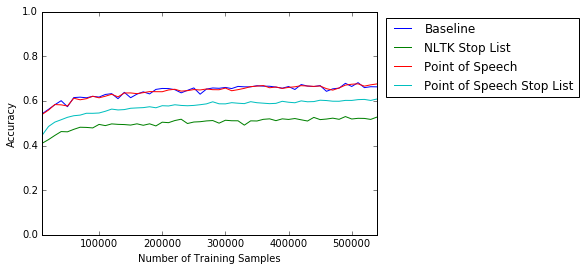

In [63]:
plt.figure()
plt.plot(range(10000,550000, 10000), nostoplist_dev)
plt.plot(range(10000,550000, 10000), stoplist_dev)
plt.plot(range(10000,550000, 10000), nostoplist_pos_dev)
plt.plot(range(10000,550000, 10000), pos_dev)
plt.legend(['Baseline', 'NLTK Stop List', 'Point of Speech', 'Point of Speech Stop List'], bbox_to_anchor=(1.62, 1.0))
plt.axis([10000, 540000, 0.0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Samples')
plt.show()